In [38]:
# import sys
# sys.path.insert(0,'/p/project/training2005/jupyter/kernels/tensorflow_test/lib/python3.6/site-packages')
# import tensorflow

import tensorflow.keras as keras
from keras import layers, Input, Model
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
ttd = np.load('redttd.npy')
ptd = np.load('redptd.npy')
ntd = np.load('/p/project/training2005/HZG_Challenge/nao_index_train.npy')

ttst = np.load('redttst.npy')
ptst = np.load('redptst.npy')

#plt.plot(range(data.shape[1]),data[0])

def _add_layer(dim, input_tensor, activ):
    if activ != '':
        x = layers.Dense(dim, activation=activ)(input_tensor)
    else: 
        x = layers.Dense(dim)(input_tensor)
    x = layers.BatchNormalization()(x)
    return x

def dense_cell(dim, input_tensor, activs):
    x = _add_layer(dim, input_tensor, activs[0])
    for a in activs[1:]:
        x = _add_layer(dim,x,a)
        
    return x


def cnn_cell(x, ks, st, filters):
    x_shortcut = x
    x = layers.Conv1D(filters=filters[0], kernel_size=1, strides=st, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters=filters[1], kernel_size=ks, strides=1, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters=filters[2], kernel_size=1, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters=1, kernel_size=1, strides=1, padding='same')(x)
#     x = layers.UpSampling1D(size=5)(x)
    x = layers.Add()([x,x_shortcut])
    x = layers.BatchNormalization()(x)
    return x

def build_model():
    inp1 = Input(shape=(5,1))
    inp2 = Input(shape=(5,1))
    #out = layers.Dense(1)(inp)
    
    #first branch
    cx = cnn_cell(inp1, 2, 1, [32,64,32])
    x = dense_cell(512, cx, ['relu']*20 + [''])
    
    #second branch
    cy = cnn_cell(inp2, 2, 1, [32,64,32])
    y = dense_cell(512, cy, ['relu']*20 + [''])
    
    #merge branches
    out = layers.Add()([x,y])
    out = layers.Flatten()(out)
    out = layers.Dense(1)(out)
    model = Model([inp1,inp2], out)
  
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary()
    return model

def train_model(model, params ={'vsplit':0.111,'ne':145,'bs':256}):
#     d1 = 
    history = model.fit([np.reshape(ttd,(ttd.shape[0],ttd.shape[1],1)),
                         np.reshape(ptd,(ptd.shape[0],ptd.shape[1],1))], 
                        np.reshape(ntd,(ntd.shape[0],1)),
                        epochs=params['ne'], 
                        batch_size=params['bs'],
                        validation_split=params['vsplit'])
    return [model, history]

def test_model(model):
    return model.predict([ttst,ptst])

def plot_losses(epochs, history):
    #ks = history.keys()
    ks =['loss','val_loss','mean_absolute_error','val_mean_absolute_error']
    [plt.plot(range(epochs), history[k],'x-') for k in ks]
    plt.show()

In [39]:
model = build_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 5, 1)         0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 5, 1)         0                                            
__________________________________________________________________________________________________
conv1d_49 (Conv1D)              (None, 5, 32)        64          input_19[0][0]                   
__________________________________________________________________________________________________
conv1d_53 (Conv1D)              (None, 5, 32)        64          input_20[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [40]:
model,loss = train_model(model, params ={'vsplit':0.111,'ne':1500,'bs':256})

Train on 800 samples, validate on 100 samples
Epoch 1/1500
800/800 [==============================] - 39s 48ms/step - loss: 6.0253 - mean_absolute_error: 1.9554 - val_loss: 7134.2764 - val_mean_absolute_error: 69.5742
Epoch 2/1500
800/800 [==============================] - 0s 313us/step - loss: 8.9633 - mean_absolute_error: 2.3615 - val_loss: 4233.2939 - val_mean_absolute_error: 48.4152
Epoch 3/1500
800/800 [==============================] - 0s 314us/step - loss: 7.3604 - mean_absolute_error: 2.1330 - val_loss: 4501.7588 - val_mean_absolute_error: 51.9067
Epoch 4/1500
800/800 [==============================] - 0s 309us/step - loss: 8.4720 - mean_absolute_error: 2.3234 - val_loss: 1449.8486 - val_mean_absolute_error: 28.9278
Epoch 5/1500
800/800 [==============================] - 0s 308us/step - loss: 8.2579 - mean_absolute_error: 2.3258 - val_loss: 2297.0950 - val_mean_absolute_error: 37.5187
Epoch 6/1500
800/800 [==============================] - 0s 308us/step - loss: 4.2783 - mean_ab

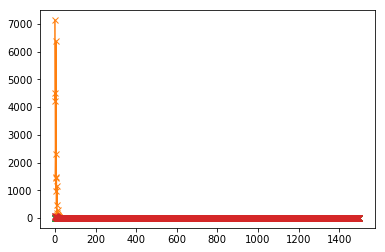

In [41]:
plot_losses(1500,loss.history)